In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import time
from sklearn.cluster import DBSCAN,KMeans,k_means
from sklearn.preprocessing import scale
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings('ignore')

In [2]:
# DS数模团队原创思路，如果您买的是盗版，请务必在公众号：DS数模，输入：mathorcup。获取D题答疑群群号
# 如果本代码出现问题或其他优化思路，会在答疑群进行更新！并且，大家有问题在答疑群中也可以问DS C君
df_1 = pd.read_csv('附件1 弱覆盖栅格数据(筛选).csv')
df_2 = pd.read_csv('附件2 现网站址坐标(筛选).csv')

In [3]:
mat = np.zeros([2500,2500])
for i in df_1.index:
    mat[df_1['x'][i]][df_1['y'][i]]=df_1['traffic'][i]

计算微基站扇形覆盖面  
（对被覆盖的地方进行标记，被覆盖为1，没被覆盖为0，方便后续使用，只有正方向左侧的，右侧使用时做一个镜像即可）

In [4]:
sec_mat10 = np.zeros([11,11])
theta = np.arange(0,np.pi/3,np.pi/30)
x = (10-theta*10/(np.pi*2/3))*np.cos(theta)
y = (10-theta*10/(np.pi*2/3))*np.sin(theta)
for i in range(len(x)):
    for j in range(int(x[i])):
        sec_mat10[int(y[i])][int(x[i])]=1
        if int(y[i])<=j:
            sec_mat10[int(y[i])][j]=1
# sec_mat10

计算宏基站扇形覆盖面

In [5]:
sec_mat30 = np.zeros([31,31])
theta = np.arange(0,np.pi/3,np.pi/30)
x = (30-theta*30/(np.pi*2/3))*np.cos(theta)
y = (30-theta*30/(np.pi*2/3))*np.sin(theta)
for i in range(len(x)):
    for j in range(int(x[i])):
        sec_mat30[int(y[i])][int(x[i])]=1
        if int(y[i])<=j:
            sec_mat30[int(y[i])][j]=1
# sec_mat30

扇形示意图

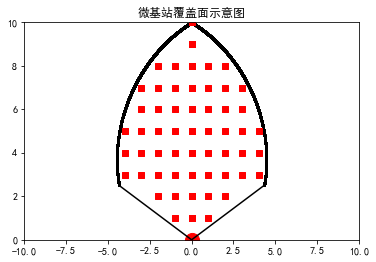

In [6]:
theta = np.arange(0,np.pi/3,np.pi/30000)
y = (10-theta*10/(np.pi*2/3))*np.cos(theta)
x = (10-theta*10/(np.pi*2/3))*np.sin(theta)
plt.scatter(x,y,c='black',s=2)
plt.scatter(-x,y,c='black',s=2)
plt.scatter([0],[0],c='red',s=200)
plt.plot([0,x[-1]],[0,y[-1]],c='black')
plt.plot([0,-x[-1]],[0,y[-1]],c='black')

for i in range(sec_mat10.shape[0]):
    for j in range(sec_mat10.shape[1]):
        if sec_mat10[i][j]:
            plt.scatter([i],[j],marker='s',c='red')
            plt.scatter([-i],[j],marker='s',c='red')

plt.xlim(-10,10)
plt.ylim(0,10)
plt.title('微基站覆盖面示意图')
plt.show()

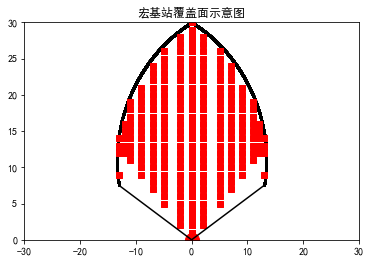

In [32]:
r=30
theta = np.arange(0,np.pi/3,np.pi/30000)
y = (r-theta*r/(np.pi*2/3))*np.cos(theta)
x = (r-theta*r/(np.pi*2/3))*np.sin(theta)
plt.scatter(x,y,c='black',s=2)
plt.scatter(-x,y,c='black',s=2)
plt.scatter([0],[0],c='red',s=200)
plt.plot([0,x[-1]],[0,y[-1]],c='black')
plt.plot([0,-x[-1]],[0,y[-1]],c='black')
for i in range(sec_mat30.shape[0]):
    for j in range(sec_mat30.shape[1]):
        if sec_mat30[i][j]:
            plt.scatter([i],[j],marker='s',c='red')
            plt.scatter([-i],[j],marker='s',c='red')
plt.xlim(-r,r)
plt.ylim(0,r)
plt.title('宏基站覆盖面示意图')
plt.show()

计算30*30每个区块的收益  

In [8]:
mat_30 = np.zeros([84,84])
for i in range(83):
    for j in range(83):
        mat_30[i][j] = mat[i*30:(i+1)*30,j*30:(j+1)*30].sum()

计算10*10每个区块的收益  

In [9]:
mat_10 = np.zeros([250,250])
for i in range(250):
    for j in range(250):
        mat_10[i][j] = np.sum(mat[i*10:(i+1)*10,j*10:(j+1)*10])

In [10]:
base_10,base_30=mat_10.sum()/6250000*100,mat_30.sum()/6250000*900

计算扇形内收益

In [11]:
def sector(mat,x,y,r,theta,mat_):
    theta=np.pi*theta/180
    ans=0
    M=np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    for i in range(mat_.shape[0]):
        for j in range(mat_.shape[1]):
            if mat_[i][j]:
                c=M@np.array([i,j])
                new_x,new_y=(c+np.sign(c)*0.2).astype('int')
                if 0<=new_x+x<2500 and 0<=-new_x+x<2500 and 0<=new_y+y<2500:
                    ans+=mat[new_x+x][new_y+y]  # 正方向左侧
                    ans+=mat[-new_x+x][new_y+y]  # 正方向右侧
    return ans

在10倍平均收益的10 * 10的区块里进行遍历，  
宏，微判断标准，角度选择（同第一问，只是增加了角度选择）    
当前点宏的收益/30区块平均收益与当前点微的收益/10区块平均收益的大小进行比较，当前者大则选择宏，否则选择微  
只记录下了最大的一个角度，收益使用最大角度收益的3倍，会有30°的地方未被覆盖，所以实际乘的11/12 * 3=33/12

In [12]:
df=[]
t=time.time()
n=0
for i in range(0, 250):
    for j in range(0, 250):
        if mat_10[i][j]>base_10*10:   #  此处*10可以改为1-10都可
            for k in range(i*10,(i+1)*10):
                for m in range(j*10,(j+1)*10):
                    max_ans=0
                    for theta in range(0,360,36):
                        big=sector(mat,k,m,30,theta,sec_mat30)
                        small = sector(mat,k,m,10,theta,sec_mat10)
                        if big/base_30>small/base_10:
                            ans,r=big,1
                        else:
                            ans,r=small,0
                        if ans>max_ans:
                            max_ans=ans
                            max_k,max_m,max_r,max_theta=k,m,r,theta
                    df.append([max_k,max_m,max_ans*33/12,max_r,max_theta])

In [13]:
df_data = pd.DataFrame(df,columns=['x','y','traffic','label','theta'])
df_data.head()

,x,y,traffic,label,theta
0,0,990,1427.760422,0,0
1,0,991,2855.520844,0,36
2,0,992,2855.520844,0,36
3,0,993,1427.760422,0,0
4,0,994,2855.520844,0,216


对现有基站最优方向，基站类型选择  
（同第一问，只是增加了角度选择）

In [14]:
count = 0
df_2['label']=0
df_2['traffic']=0
df_2['theta'] = 0
for i in df_2.index:
    max_ans=0
    for theta in range(0,360,36):
        big = sector(mat,df_2['x'][i],df_2['y'][i],30,theta,sec_mat30)
        small = sector(mat,df_2['x'][i],df_2['y'][i],10,theta,sec_mat10)
        if big/base_30>small/base_10:
            ans,r=big,1
        else:
            ans,r=small,0
        if ans>max_ans:
            max_ans,max_theta,max_r = ans,theta,r
    df_2['label'][i]=max_r
    df_2['traffic'][i]=max_ans*33/12  
    df_2['theta'][i] = max_theta

In [15]:
df_2['traffic'].sum()/np.sum(mat)*100

81.12722951215423

剔除与现有基站相交的基站

In [16]:
# DS数模团队原创思路，如果您买的是盗版，请务必在公众号：DS数模，输入：mathorcup。获取D题答疑群群号
# 如果本代码出现问题或其他优化思路，会在答疑群进行更新！并且，大家有问题在答疑群中也可以问DS C君
use = []
for i in df_data.index:
    data=np.array(df_data.values[i,:2])
    if df_data.values[i,3]:
        if (np.linalg.norm(df_2[['x','y']].values-data,axis=1)<=40).any():
            continue
        if (np.linalg.norm(df_2[df_2['label']==1][['x','y']].values-data,axis=1)<=60).any():
            continue
    else:
        if (np.linalg.norm(df_2[['x','y']].values-data,axis=1)<=20).any():
            continue
        if (np.linalg.norm(df_2[df_2['label']==1][['x','y']].values-data,axis=1)<=40).any():
            continue
    use.append(i)
use

[100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 271,
 272,
 273

聚类，同第一问

In [17]:
db=DBSCAN(10,min_samples=1,n_jobs=4)
db.fit(df_data.values[:,:2])
db.labels_
labels=np.unique(db.labels_)

In [18]:
uses = []
for label in labels:
    max_ = 0
    flag=0
    for i in use:
        if label == db.labels_[i]:
            if max_ < df_data.values[i,2]:
                max_ = df_data.values[i,2]
                max_i=i
                flag=1
    if flag:
        uses.append(max_i)

In [19]:
df_data.values[uses,:]

array([[6.00000000e+00, 1.35000000e+03, 9.34322948e+03, 0.00000000e+00,
        3.60000000e+01],
       [7.00000000e+00, 1.57500000e+03, 1.15031094e+04, 0.00000000e+00,
        3.60000000e+01],
       [7.00000000e+00, 1.70700000e+03, 1.19197846e+04, 0.00000000e+00,
        2.16000000e+02],
       ...,
       [2.48300000e+03, 1.81100000e+03, 1.27708902e+04, 0.00000000e+00,
        3.60000000e+01],
       [2.49700000e+03, 1.48700000e+03, 6.87150891e+03, 0.00000000e+00,
        2.16000000e+02],
       [2.49600000e+03, 2.39900000e+03, 2.90863525e+04, 0.00000000e+00,
        2.16000000e+02]])

新建基站收益

In [20]:
np.sum(df_data.values[uses,2])/np.sum(mat)*100/3

33.96858453795075

In [21]:
df_2['traffic'].sum()/np.sum(mat)*100/3

27.042409837384742

总收益  
（只输出了最大的一个扇形的收益）

In [22]:
np.sum(df_data.values[uses,2])/np.sum(mat)*100/3+df_2.loc[:,'traffic'].sum()/np.sum(mat)*100/3

61.010994375335486

In [23]:
df_ans = df_2.copy()
df_ans.shape

(1474, 6)

In [24]:
df_ans=df_ans.append(df_data.iloc[uses,:],ignore_index=True)
df_ans.head()

,id,x,y,label,traffic,theta
0,1.0,818,2020,1,0.0,180
1,4.0,713,2013,1,0.0,180
2,33.0,2305,291,1,1608.0,180
3,35.0,700,1953,1,0.0,180
4,36.0,949,2293,1,0.0,180


In [25]:
df_ans1=df_ans.copy()

根据最大，左右45°分别一个扇形

In [26]:
df_ans['theta1']=df_ans['theta']-45
df_ans['theta2']=df_ans['theta']+45

In [27]:
for i in df_ans.index:
    if df_ans['label'][i]:
        df_ans['traffic'][i]=sector(mat,df_ans['x'][i],df_ans['y'][i],30,df_ans['theta'][i],sec_mat30)
        df_ans['traffic'][i]+=sector(mat,df_ans['x'][i],df_ans['y'][i],30,df_ans['theta1'][i],sec_mat30)
        df_ans['traffic'][i]+=sector(mat,df_ans['x'][i],df_ans['y'][i],30,df_ans['theta2'][i],sec_mat30)
    else:
        df_ans['traffic'][i]=sector(mat,df_ans['x'][i],df_ans['y'][i],10,df_ans['theta'][i],sec_mat10)
        df_ans['traffic'][i]+=sector(mat,df_ans['x'][i],df_ans['y'][i],10,df_ans['theta1'][i],sec_mat10)
        df_ans['traffic'][i]+=sector(mat,df_ans['x'][i],df_ans['y'][i],10,df_ans['theta2'][i],sec_mat10)

最终收益

In [28]:
np.sum(df_ans['traffic'])/np.sum(mat)*100

102.09892990181784

In [29]:
df_ans.to_excel('第二问结果.xlsx')